In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Paths to the data
train_data_path = r'/kaggle/input/human-action-recognition-new/Human Action Recognition/train'
test_data_path = r'/kaggle/input/human-action-recognition-new/Human Action Recognition/test'

In [10]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

In [11]:
# Create DataLoader for training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

#### Run all cells till this point.

### Load the pre-trained DenseNet-121 model

In [12]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

# Load DenseNet121
model = models.densenet121(pretrained=True)

# Freeze all the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Freeze all the classification layers except the last one
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 5)

# Unfreeze the last classification layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Move the model to the device
model = model.to(device)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
# Define loss function and optimizer (only train the last classification layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)


In [14]:
# Define loss function and optimizer (only train the last classification layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)

In [15]:
import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

Epoch [1/20], Train Loss: 0.5864, Train Accuracy: 78.01%
Test Loss: 0.2795, Test Accuracy: 89.84%
Updated best model with accuracy: 89.84%
Epoch [2/20], Train Loss: 0.3473, Train Accuracy: 87.48%
Test Loss: 0.2473, Test Accuracy: 90.79%
Updated best model with accuracy: 90.79%
Epoch [3/20], Train Loss: 0.3192, Train Accuracy: 89.02%
Test Loss: 0.3682, Test Accuracy: 88.10%
Epoch [4/20], Train Loss: 0.2679, Train Accuracy: 90.25%
Test Loss: 0.3130, Test Accuracy: 90.00%
Epoch [5/20], Train Loss: 0.2545, Train Accuracy: 90.56%
Test Loss: 0.2303, Test Accuracy: 91.27%
Updated best model with accuracy: 91.27%
Epoch [6/20], Train Loss: 0.2512, Train Accuracy: 90.70%
Test Loss: 0.2494, Test Accuracy: 91.27%
Epoch [7/20], Train Loss: 0.2281, Train Accuracy: 91.85%
Test Loss: 0.2878, Test Accuracy: 90.16%
Epoch [8/20], Train Loss: 0.2479, Train Accuracy: 90.95%
Test Loss: 0.2761, Test Accuracy: 91.11%
Epoch [9/20], Train Loss: 0.2207, Train Accuracy: 92.04%
Test Loss: 0.3548, Test Accuracy: 88

### Plot: Epochs vs Train Loss and Test Loss

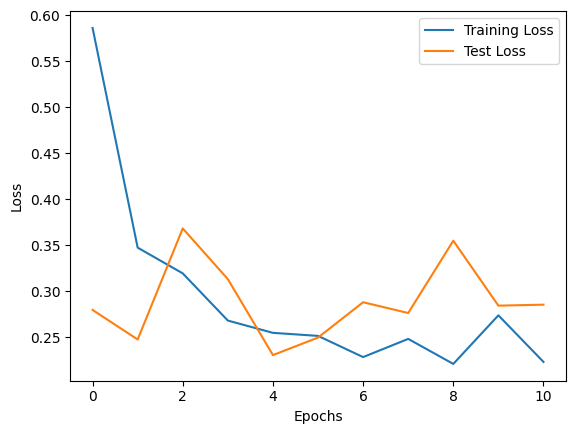

In [17]:
# Plotting the epochs vs training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()